## Problem Set 8

### Victoria Gregory, N14207660

**4/5/2016**

### Exercise 1

Suppose that $S$ is infinite. Consider the sequence of distributions over $S$ that place all mass on just one point. There cannot exist a finite subcover of this if you use $\epsilon$-balls of size $\frac{1}{2}$. Therefore, $S$ cannot be compact, a contradiction.

### Exercise 2

Suppose that there did exist a stationary distribution $\psi^*$. Let's try to update it:

\begin{align*}
\psi^*(y) &= \displaystyle \sum_{x \in S} p(x,y) \psi^*(x) \\
&= \displaystyle \sum_{x \in S} \mathbb{1}\{x = y-1\} \psi^*(x) \\
&= \psi^*(y-1)
\end{align*}

This should work for any $y$, and it should sum to 1 over all $y$. But since $\mathbb{Z}$ is infinite, it will sum to $\infty$ -- contradiction. So there cannot be a stationary distribution.

### Exercise 3

First, I'll describe the general form that the stochastic matrix, $P$, is going to take given a $(q, Q)$ pair. Note that it's going to be $(Q+1) \times (Q+1)$ because the state space is the set of integers between 0 and $Q$. 

* If $X_t \leq q$, then the firm can fully restock to $Q$ so that it can meet any demand that may be realized. So tomorrow's inventory, $X_{t+1}$ can take on any value in the state space, with probability determined by the probability distribution of $D$. So the first $q + 1$ rows of $P$ will be:

$$
\begin{bmatrix}
(1/2)^{Q} & (1/2)^{Q} & (1/2)^{Q-1} & ... & (1/2)^2 & (1/2)
\end{bmatrix}
$$

* If $X_t > q$, the firm doesn't restock. So $X_{t+1}$ cannot be greater than $X_t$ because demand will be at least zero. So the above diagonal elements in rows beyond $q+1$ will be zeros. The rest are determined by by the probability distribution of $D$: they will start at $\frac{1}{2}$ on the diagonal, and moving left will be $\frac{1}{4}$, $\frac{1}{8}$, etc...

This matrix is going to be globally stable for any $(q,Q)$ pair. It's clearly irreducible: you can eventually get from any state to any other state. It's also aperiodic. We can easily see that state 0 is aperiodic because the process can return to 0 at any time: it doesn't need to be after a certain number of periods. Since we have found one aperiodic state, and the Markov chain is irreducible, then the whole Markov chain will be aperiodic. Therefore, the chain will be globally stable because it is irreducible and aperiodic, and the state space is finite.

### Exercise 4

Now we are going to numerically compute the stationary distribution of the stochastic kernel discussed in the last problem. I start by defining a function that computes the probability of demand for a given $d$:

In [1]:
# function to return probability of a given d
function pr_D(d)
    return (1/2)^(d+1)
end

pr_D (generic function with 1 method)

Next, I create a function that creates the stochastic matrix $P$ given a $(q, Q)$ pair:

In [2]:
function form_P(q,Q)

    P = zeros(Q+1,Q+1);

    # first q+1 rows are going to be the same
    for i = Q+1:-1:2
        p = pr_D(Q+1-i);
        P[1:q+1,i] = p.*ones(q+1,1);
    end
    
    # fill in the rest of the rows
    for i = q+2:Q+1
        for j = Q+1:-1:2
            if j>i
                continue;
            else
                diff     = abs(j-i)
                P[i,j]   = pr_D(diff);
            end
        end
    end
    
    # fill in first column with residual probabilities
    P[:,1] = 1 - sum(P,2);
    
    return P;
end

form_P (generic function with 1 method)

Given that $q=2$ and $Q=5$, I can simply create the Markov chain using the function above and use the `MarkovChain` class to find the stationary distribution.

In [11]:
using QuantEcon

# find stationary distribution of P using QuantEcon
q = 2;
Q = 5;
P = form_P(q,Q);
mc = MarkovChain(P);
stat_dist1 = mc_compute_stationary(mc)

6-element Array{Float64,1}:
 0.0625
 0.0625
 0.125 
 0.25  
 0.25  
 0.25  

### Exercise 5

Alternatively, I can compute the stationary distribution using an iterative method. The idea is to start with some distribution over states, use the Markov chain to compute next period's distribution, and repeat this process until the distribution eventually settles down. I check for convergence by computing the $\ell_1$ distance between successive distributions and stopping when it is within a given tolerance level. The following function implements this process:

In [6]:
# find stationary distribution iteratively
function find_stat(P)

    guess = ones(1,size(P,1)).*(1/size(P,1))
    tol = 1e-6;
    dist = 1;
    
    while dist > tol
        new_guess = guess*P;
        dist = sum(abs(new_guess - guess));
        guess = new_guess;
    end

return guess;
end

find_stat (generic function with 1 method)

Now I can just call this function on our matrix $P$. As expected, I get the same answer as in the last problem.

In [8]:
stat_dist2 = find_stat(P)

1x6 Array{Float64,2}:
 0.0625  0.0625  0.125  0.25  0.25  0.25

### Exercise 6

Now we're going to plot the stationary distribution for different values of $q$.

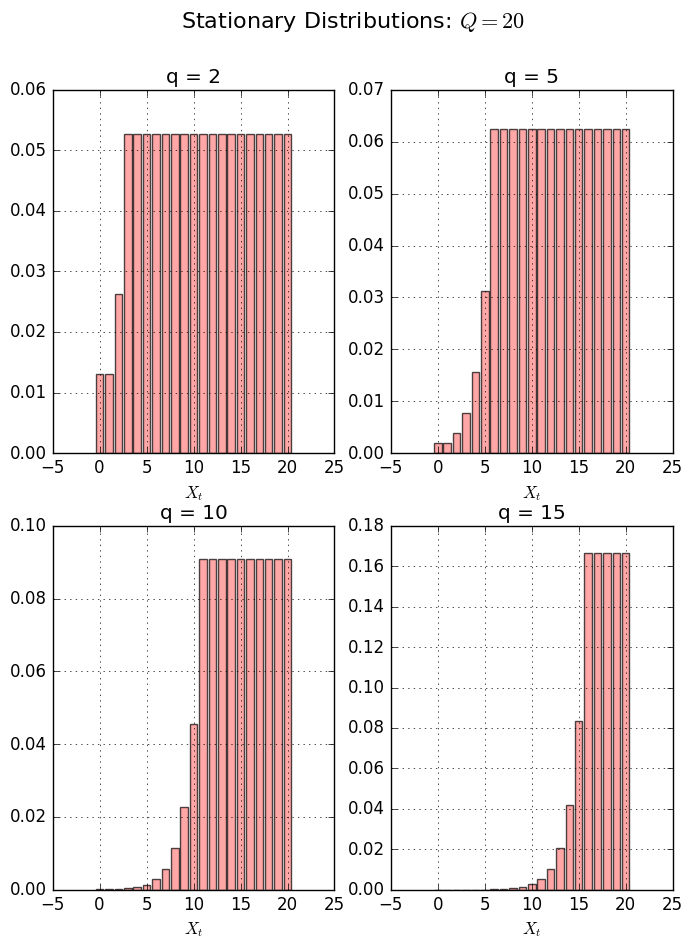

PyObject <matplotlib.text.Text object at 0x32d0e9750>

In [93]:
using PyPlot

qs = [2 5 10 15];
Q  = 20;
plotnum = 221;
fig = figure("stat_dists",figsize=(8,10))

for i=1:length(qs)
    
    # find stationary distribution
    q = qs[i];
    P = form_P(q,Q);
    dist = find_stat(P)
    
    # create plot
    subplot(plotnum)
    state = collect(0:Q)
    b = bar(state,dist',color="#ff8080",align="center",alpha=0.7)
    title("q = $q")
    grid("on")
    xlabel(L"$X_t$")
    
    plotnum = plotnum+1;
end

suptitle(L"Stationary Distributions: $Q=20$",fontsize=16)

Observe that at low values of inventory, there is less mass because firms are close to the restocking threshold $q$. States below $q$ are states are states where it is possible to go anywhere next period. The distribution becomes more skewed the higher $q$ is. When $q$ is low, firms restock less often, meaning there will be more dispersion in their inventory stock. In this situation, they just let demand run down their stock until they decide to restock when their inventory falls below $q$. For example, in the $q=2$ plot, firms are equally likely to be at any inventory state greater than 3. 